In [12]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo

In [13]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [15]:
# Get a set of pretrained model weights
weights = torchvision.models.AlexNet_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [17]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=5)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c2fb71f650>,
 ['high', 'low', 'medium'])

In [18]:
model = torchvision.models.alexnet(weights=weights).to(device)

In [19]:
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.parameters():
#     param.requires_grad = False

In [20]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=9216, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=8,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 12%|█▎        | 1/8 [00:18<02:08, 18.35s/it]

Epoch: 1 | train_loss: 1.0618 | train_acc: 0.4333 | test_loss: 0.8194 | test_acc: 0.6000


 25%|██▌       | 2/8 [00:36<01:48, 18.06s/it]

Epoch: 2 | train_loss: 0.6116 | train_acc: 0.7111 | test_loss: 0.6038 | test_acc: 0.7200


 38%|███▊      | 3/8 [00:54<01:31, 18.27s/it]

Epoch: 3 | train_loss: 0.3685 | train_acc: 0.8889 | test_loss: 0.5306 | test_acc: 0.8400


 50%|█████     | 4/8 [01:13<01:13, 18.30s/it]

Epoch: 4 | train_loss: 0.1299 | train_acc: 0.9778 | test_loss: 0.5826 | test_acc: 0.7600


 62%|██████▎   | 5/8 [01:31<00:55, 18.50s/it]

Epoch: 5 | train_loss: 0.0811 | train_acc: 0.9889 | test_loss: 0.5541 | test_acc: 0.8000


 75%|███████▌  | 6/8 [01:51<00:37, 18.80s/it]

Epoch: 6 | train_loss: 0.1101 | train_acc: 0.9556 | test_loss: 0.3349 | test_acc: 0.9200


 88%|████████▊ | 7/8 [02:10<00:18, 18.91s/it]

Epoch: 7 | train_loss: 0.0336 | train_acc: 1.0000 | test_loss: 0.4126 | test_acc: 0.8800


100%|██████████| 8/8 [02:30<00:00, 18.77s/it]

Epoch: 8 | train_loss: 0.0098 | train_acc: 1.0000 | test_loss: 0.4929 | test_acc: 0.8000
[INFO] Total training time: 150.154 seconds


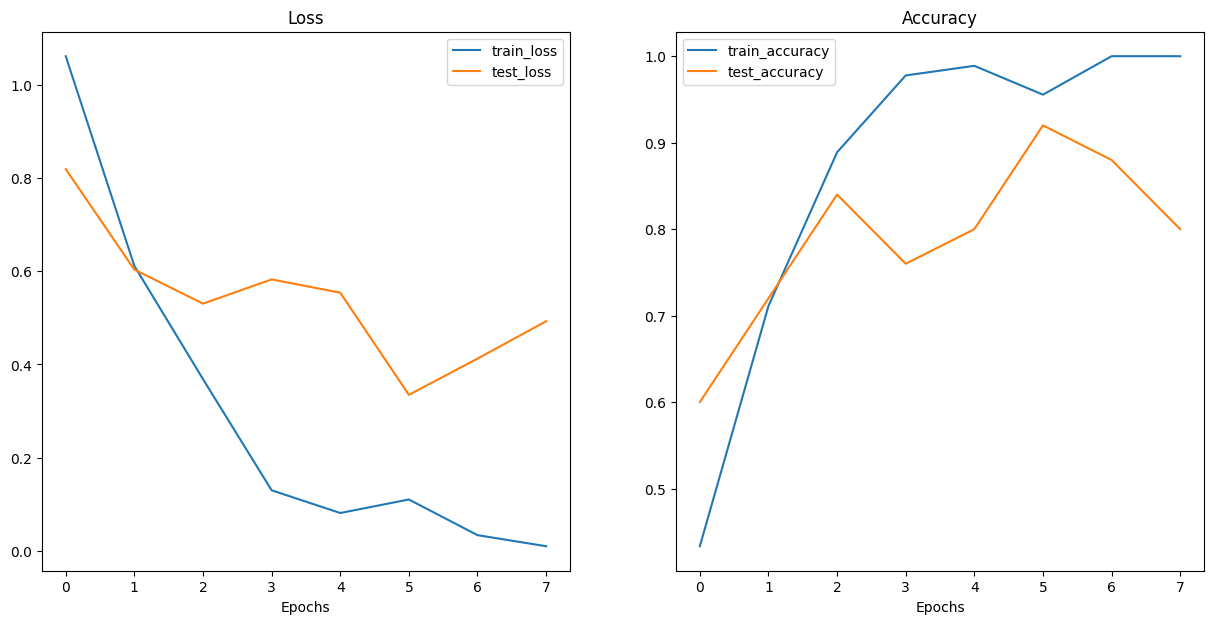

In [23]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)